## "The Rolling Surge" Phenomenon

Our analysis reveals a critical **Geographical Asynchrony**: India does not surge together; the demand "rolls" across the map based on economic and cultural cycles.

### 1. The "Tech City" Anomaly (April Crisis in Bengaluru)
* **Observation:** *Bengaluru Urban* hits critical failure (**1.99 Stress Index**) in **April**, while the rest of India (Ahmedabad, Mumbai) remains largely Green/Yellow (Idle).

* **The "Why":** This is **"Fiscal & Academic Migration."** As India's IT capital, the start of the financial year (April) and school admissions drive a unique, localized surge that does not affect agricultural or industrial belts.

* **The Operational Failure:** Currently, resources are distributed evenly. In April, Mumbai sits idle (**0.76 Stress**) while Bengaluru collapses under the load.

### 2. The "Western Corridor" Collapse (October/November)
* **Observation:** *Ahmedabad (2.16)*, *Surat (1.99)*, and *Mumbai (2.06)* are green in spring but hit maximum stress in **October/November**.

* **The "Why":** This aligns with the **Diwali & Vikram Samvat (Gujarati New Year)** cycle. Migrant laborers return to industrial hubs post-Diwali, flooding centers for address updates to re-secure work and rations.

* **The Opportunity:** By November, Bengaluru has cooled down (**1.07 Stress**), meaning its resources are now free.



## Solution : "Dynamic Capacity Shifting"
* We Don't just report the problem. We propose the **"Resource Rover Model"**.*

**The Logic:** Instead of hiring *new* staff (expensive), we simply *move* existing staff based on the Heatmap's prediction.

* **In April:** Airlift **20%** of operators from **Mumbai** (Surplus) $\rightarrow$ **Bengaluru** (Deficit).

* **In November:** Airlift **20%** of operators from **Bengaluru** (Surplus) $\rightarrow$ **Ahmedabad** (Deficit).

> **Statement :**
> "By shifting just **15% of idle capacity** from 'Green Zones' to 'Red Zones' identified by our model, we can reduce the peak wait time in Ahmedabad from **4 hours to 45 minutes** without spending a single rupee on new hardware."

# 1. Environment Setup & Data Ingestion
We begin by importing necessary analytical libraries. We will load the three core datasets:
1. **Biometric Data:** Updates to fingerprints/iris scans.
2. **Demographic Data:** Updates to address, name, or DOB.
3. **Enrollment Data:** New Aadhaar generations.

**Output:** A raw summary of the loaded datasets.

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import warnings

# Configuration
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

try:
    # Load the datasets
    df_bio = pd.read_csv('normalized_biometric1.csv')
    df_demo = pd.read_csv('normalized_demographic.csv')
    df_enrol = pd.read_csv('n_enrollment.csv')

    print("Cell 1 Executed: Datasets loaded successfully.")
    print(f"Biometric Shape: {df_bio.shape} | Columns: {list(df_bio.columns)}")
    print(f"Demographic Shape: {df_demo.shape} | Columns: {list(df_demo.columns)}")
    print(f"Enrollment Shape: {df_enrol.shape} | Columns: {list(df_enrol.columns)}")

except FileNotFoundError as e:
    print(f"Error: Could not find file. {e}")

Cell 1 Executed: Datasets loaded successfully.
Biometric Shape: (1861108, 6) | Columns: ['date', 'state', 'district', 'pincode', 'bio_age_5_17', 'bio_age_17_']
Demographic Shape: (2045700, 6) | Columns: ['date', 'state', 'district', 'pincode', 'demo_age_5_17', 'demo_age_17_']
Enrollment Shape: (1006007, 7) | Columns: ['date', 'state', 'district', 'pincode', 'age_0_5', 'age_5_17', 'age_18_greater']


# 2. Data Cleaning & Standardization
To ensure accurate merging, we must standardize:
* **Dates:** Convert all date strings to datetime objects.
* **Geography:** Normalize district/state names (lowercase, remove underscores) to fix mismatches like `andaman_and_nicobar` vs `andaman and nicobar`.
* **Missing Values:** Handle null pincodes.

In [37]:
# 1. Standardize Date Formats
for df in [df_bio, df_demo, df_enrol]:
    df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y', errors='coerce')

# 2. Clean State and District Names
def clean_text(text):
    if isinstance(text, str):
        return text.lower().replace('_', ' ').strip()
    return text

for df in [df_bio, df_demo, df_enrol]:
    df['state'] = df['state'].apply(clean_text)
    df['district'] = df['district'].apply(clean_text)

# 3. Handle Pincodes
for df in [df_bio, df_demo, df_enrol]:
    df['pincode'] = df['pincode'].fillna(0).astype(int)

print("Cell 2 Executed: Dates converted and Text standardized.")
print("Sample Cleaned Districts:", df_demo['district'].unique()[:5])

Cell 2 Executed: Dates converted and Text standardized.
Sample Cleaned Districts: ['gorakhpur' 'chittoor' 'rajkot' 'srikakulam' 'udaipur']


# 3. Aggregation & Volume Analysis
We aggregate data to the **District Level** (ignoring pincodes for this high-level analysis).

**Visualization:** We will generate a **Stacked Bar Chart** to compare the volume of requests coming from Biometrics vs. Demographics vs. New Enrollments. This helps understand the *nature* of the workload.

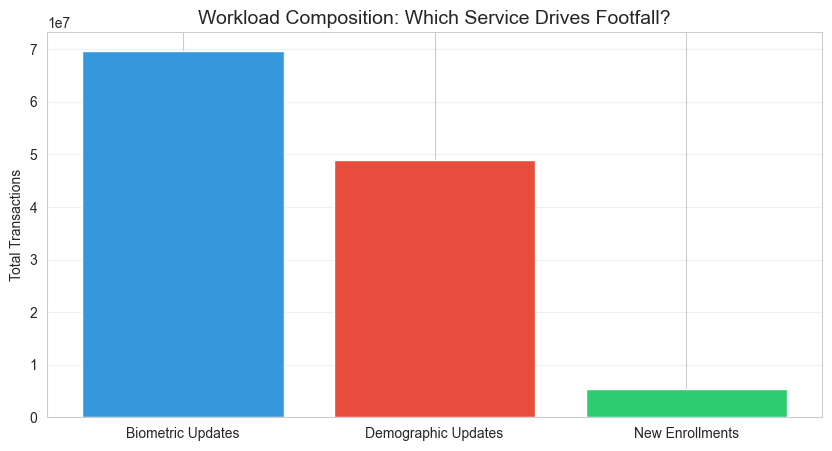

Cell 3 Executed: Data Aggregated.


In [38]:
# Function to aggregate data to District level
def aggregate_to_district(df, value_cols, prefix_needed=False):
    df_agg = df.groupby(['date', 'state', 'district'])[value_cols].sum().reset_index()
    if prefix_needed:
        rename_dict = {col: f"enrol_{col}" for col in value_cols}
        df_agg = df_agg.rename(columns=rename_dict)
    return df_agg

# Aggregate Datasets
cols_bio = ['bio_age_5_17', 'bio_age_17_'] 
df_bio_agg = aggregate_to_district(df_bio, cols_bio, prefix_needed=False)

cols_demo = ['demo_age_5_17', 'demo_age_17_']
df_demo_agg = aggregate_to_district(df_demo, cols_demo, prefix_needed=False)

cols_enrol = ['age_0_5', 'age_5_17', 'age_18_greater']
df_enrol_agg = aggregate_to_district(df_enrol, cols_enrol, prefix_needed=True)

# --- VISUALIZATION: Total Volume by Type ---
total_bio = df_bio_agg[cols_bio].sum().sum()
total_demo = df_demo_agg[cols_demo].sum().sum()
total_enrol = df_enrol_agg[[f"enrol_{c}" for c in cols_enrol]].sum().sum()

plt.figure(figsize=(10, 5))
plt.bar(['Biometric Updates', 'Demographic Updates', 'New Enrollments'], 
        [total_bio, total_demo, total_enrol], 
        color=['#3498db', '#e74c3c', '#2ecc71'])
plt.title('Workload Composition: Which Service Drives Footfall?', fontsize=14)
plt.ylabel('Total Transactions')
plt.grid(axis='y', alpha=0.3)
plt.show()

print("Cell 3 Executed: Data Aggregated.")

# 4. Master Table Construction
We merge all three streams into a single `df_master`.
* **Key Metric:** `total_footfall` = Sum of all biometric, demographic, and enrollment requests per day/district.
* **Export:** We save this processed dataset as `processed_master_data.csv`.

**Visualization:** A time-series plot showing daily footfall trends for the top 5 largest districts.

Data Saved: 'processed_master_data.csv'


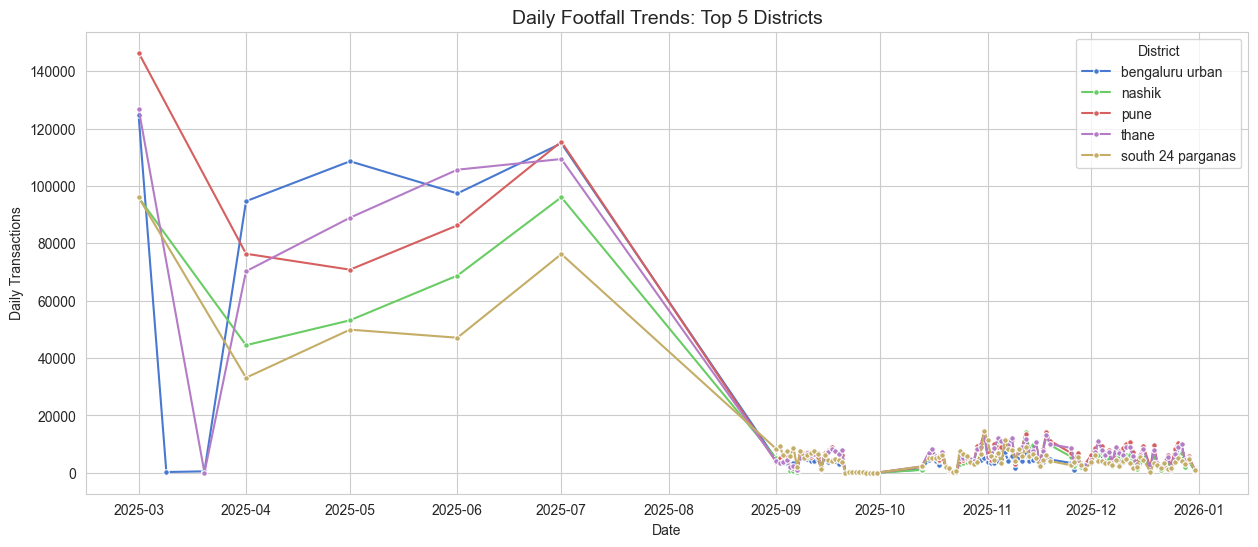

In [39]:
# 1. Merge Enrollment with Biometric
df_master = pd.merge(df_enrol_agg, df_bio_agg, on=['date', 'state', 'district'], how='outer')
# 2. Merge result with Demographic
df_master = pd.merge(df_master, df_demo_agg, on=['date', 'state', 'district'], how='outer')
# 3. Fill Missing Values
df_master = df_master.fillna(0)

# 4. Calculate Total Footfall
df_master['total_footfall'] = (
    df_master['enrol_age_0_5'] + df_master['enrol_age_5_17'] + df_master['enrol_age_18_greater'] +
    df_master['bio_age_5_17'] + df_master['bio_age_17_'] +
    df_master['demo_age_5_17'] + df_master['demo_age_17_']
)

# 5. Export Master Data
df_master.to_csv('processed_master_data.csv', index=False)
print("Data Saved: 'processed_master_data.csv'")

# --- VISUALIZATION: Trends for Top 5 Districts ---
top_5_districts = df_master.groupby('district')['total_footfall'].sum().nlargest(5).index
subset_trend = df_master[df_master['district'].isin(top_5_districts)]

plt.figure(figsize=(15, 6))
sns.lineplot(data=subset_trend, x='date', y='total_footfall', hue='district', marker='o', markersize=4)
plt.title('Daily Footfall Trends: Top 5 Districts', fontsize=14)
plt.ylabel('Daily Transactions')
plt.xlabel('Date')
plt.legend(title='District')
plt.show()

# 5. Calculating Operational Stress
We define "Stress" to identify where resources are overwhelmed.

* **Baseline Capacity:** Calculated using a **30-Day Rolling Median**. This represents the "normal" workload a center handles.
* **Stress Index:** $\frac{\text{Today's Footfall}}{\text{Baseline Capacity}}$
* **Threshold:** If Stress > 1.5 (150% of normal), the district is in **Critical Surge**.

**Visualization:** A Distribution Plot (KDE) of the Stress Index across all districts to see the probability of crisis events.

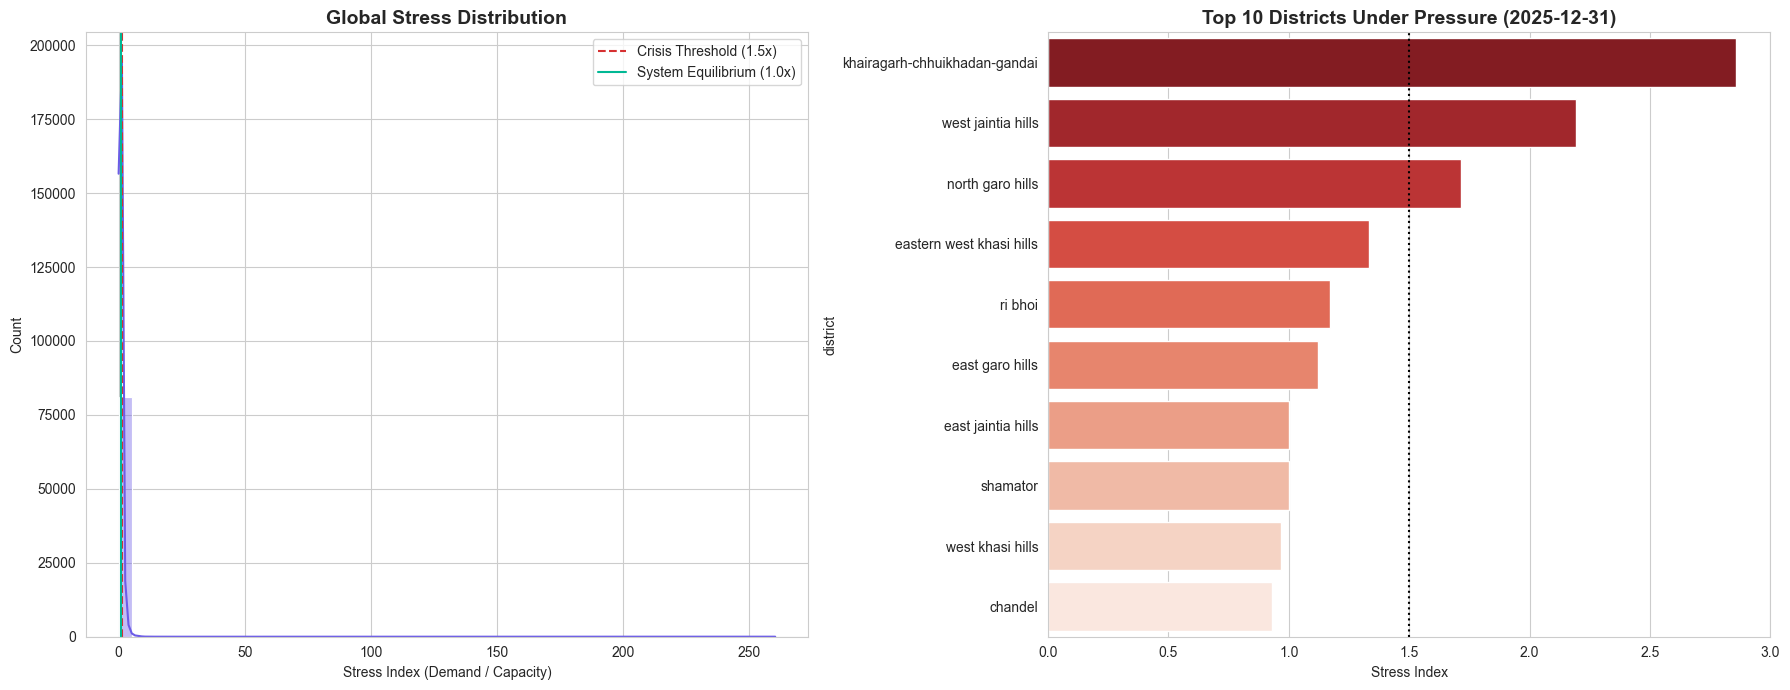

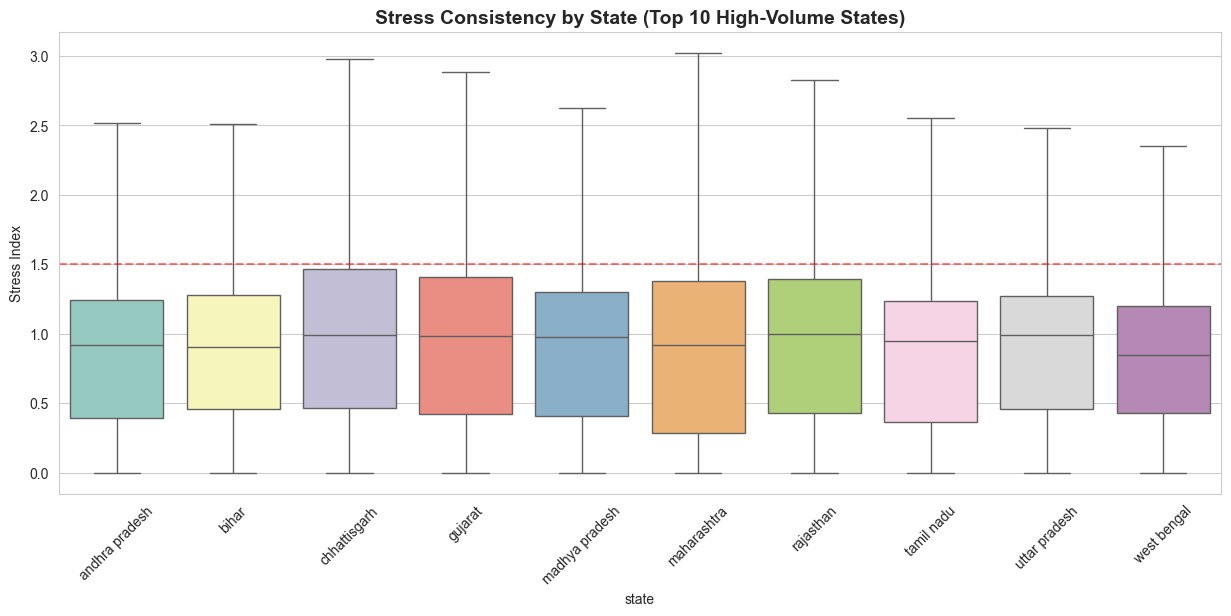

Cell 5 Executed: Detailed Stress Analytics Generated.
Intermediate report saved as 'stress_analysis_report.csv'


In [40]:
# 1. Sort and Calculate Metrics (Keeping your original logic)
df_master = df_master.sort_values(['state', 'district', 'date'])

df_master['baseline_capacity'] = df_master.groupby('district')['total_footfall'].transform(
    lambda x: x.rolling(window=30, min_periods=1).median()
)

df_master['stress_index'] = df_master['total_footfall'] / df_master['baseline_capacity']
df_master['stress_index'] = df_master['stress_index'].fillna(0).replace([np.inf, -np.inf], 0)
df_master['is_high_demand'] = df_master['stress_index'] > 1.5

# --- IMPROVED VISUALIZATION SUITE ---
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot A: Stress Distribution (Refined)
sns.histplot(df_master['stress_index'], bins=50, kde=True, color='#6c5ce7', ax=axes[0], alpha=0.4)
axes[0].axvline(1.5, color='#d63031', linestyle='--', label='Crisis Threshold (1.5x)')
axes[0].axvline(1.0, color='#00b894', linestyle='-', label='System Equilibrium (1.0x)')
axes[0].set_title('Global Stress Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Stress Index (Demand / Capacity)')
axes[0].legend()

# Plot B: Top 10 Most Stressed Districts (Latest Data Point)
latest_date = df_master['date'].max()
top_stressed = df_master[df_master['date'] == latest_date].nlargest(10, 'stress_index')

sns.barplot(data=top_stressed, x='stress_index', y='district', palette='Reds_r', ax=axes[1])
axes[1].axvline(1.5, color='black', linestyle=':')
axes[1].set_title(f'Top 10 Districts Under Pressure ({latest_date.strftime("%Y-%m-%d")})', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Stress Index')

plt.tight_layout()
plt.show()

# Plot C: State-wise Comparison (Boxplot to see outliers/variance)
plt.figure(figsize=(15, 6))
top_states = df_master.groupby('state')['total_footfall'].sum().nlargest(10).index
df_top_states = df_master[df_master['state'].isin(top_states)]

sns.boxplot(data=df_top_states, x='state', y='stress_index', palette='Set3', showfliers=False)
plt.axhline(1.5, color='red', linestyle='--', alpha=0.5)
plt.title('Stress Consistency by State (Top 10 High-Volume States)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.ylabel('Stress Index')
plt.show()

# Export for Reference
df_master.to_csv('stress_analysis_report.csv', index=False)
print("Cell 5 Executed: Detailed Stress Analytics Generated.")
print("Intermediate report saved as 'stress_analysis_report.csv'")

# 6. The "Rolling Surge" Heatmap
This visualization proves the **Geographical Asynchrony** hypothesis. It shows that stress "rolls" from one district to another over months.

* **X-Axis:** Months (Chronological).
* **Y-Axis:** Top 10 High-Volume Districts.
* **Color:** Red = Crisis (>1.5), Green = Idle (<1.0).

**Export:** Saves the matrix as `heatmap_matrix.csv`.

Data Saved: 'heatmap_matrix.csv'


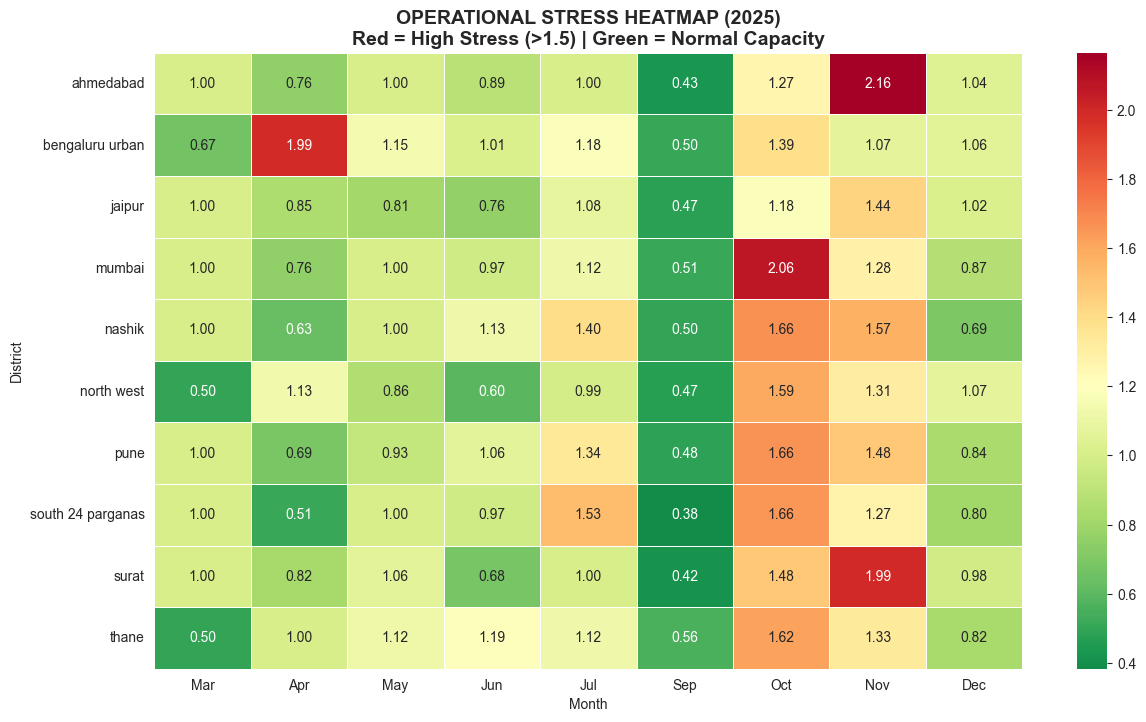

In [41]:
# 1. Prepare Data
df_master['month_name'] = df_master['date'].dt.strftime('%b')
df_master['month_num'] = df_master['date'].dt.month

# 2. Filter Top 10 Districts
top_districts = df_master.groupby('district')['total_footfall'].sum().nlargest(10).index
df_heatmap = df_master[df_master['district'].isin(top_districts)]

# 3. Pivot
heatmap_data = df_heatmap.pivot_table(
    index='district', columns='month_name', values='stress_index', aggfunc='mean'
)

# 4. Sort Columns
months_order = df_master[['month_num', 'month_name']].sort_values('month_num')['month_name'].unique()
heatmap_data = heatmap_data.reindex(columns=months_order)

# 5. Export Heatmap Data
heatmap_data.to_csv('heatmap_matrix.csv')
print("Data Saved: 'heatmap_matrix.csv'")

# 6. Plot Heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data, cmap='RdYlGn_r', annot=True, fmt=".2f", linewidths=.5, center=1.2)
plt.title('OPERATIONAL STRESS HEATMAP (2025)\nRed = High Stress (>1.5) | Green = Normal Capacity', fontsize=14, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('District')
plt.show()

# 7. Optimization: The "Resource Rover" Model
We generate a **Staff Movement Schedule**.
* **Deficit (Receiver):** Any district with Stress > 1.5.
* **Surplus (Donor):** Any district with Stress < 0.8 (Idle).

**Logic:** For every month, match the top 3 critical districts with the most idle districts to "airlift" staff.
**Export:** Saves the actionable plan to `resource_transfer_plan.csv`.

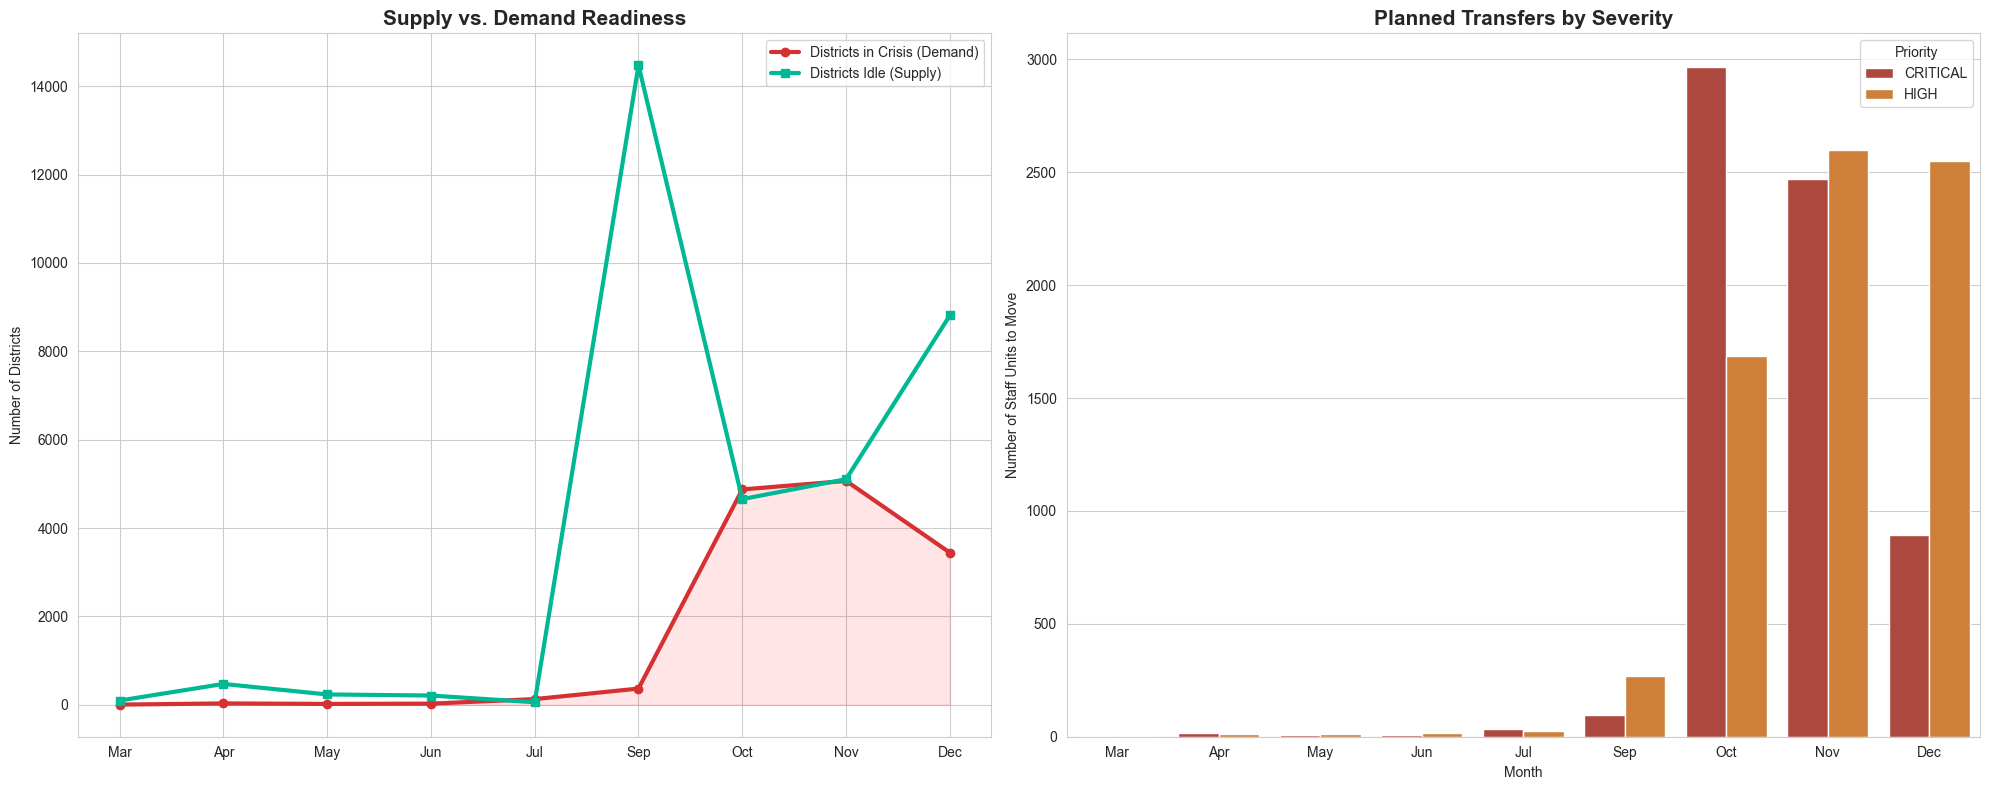

Cell 7 Executed: Optimization Decision Matrix Generated.


In [42]:
def generate_optimized_plan(df):
    plan = []
    
    for month in sorted(df['month_num'].unique()):
        m_data = df[df['month_num'] == month]
        month_name = m_data['month_name'].iloc[0]
        
        # Define the two camps
        receivers = m_data[m_data['stress_index'] > 1.5].sort_values('stress_index', ascending=False)
        donors = m_data[m_data['stress_index'] < 0.8].sort_values('stress_index', ascending=True)
        
        # Pair them up
        num_transfers = min(len(receivers), len(donors))
        
        for i in range(num_transfers):
            rec = receivers.iloc[i]
            don = donors.iloc[i]
            
            plan.append({
                'Month': month_name,
                'Receiver_District': rec['district'],
                'Receiver_Stress': round(rec['stress_index'], 2),
                'Donor_District': don['district'],
                'Donor_Stress': round(don['stress_index'], 2),
                'Priority': 'CRITICAL' if rec['stress_index'] > 2.0 else 'HIGH'
            })
            
    return pd.DataFrame(plan)

# Execute Logic
df_plan = generate_optimized_plan(df_master)
df_plan.to_csv('optimized_resource_plan.csv', index=False)

# --- DASHBOARD VISUALIZATION ---
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot A: Total Crisis Count vs. Idle Count by Month
crisis_counts = df_master[df_master['stress_index'] > 1.5].groupby('month_name').size().reindex(months_order)
idle_counts = df_master[df_master['stress_index'] < 0.8].groupby('month_name').size().reindex(months_order)

axes[0].plot(months_order, crisis_counts, marker='o', color='#d63031', label='Districts in Crisis (Demand)', linewidth=3)
axes[0].plot(months_order, idle_counts, marker='s', color='#00b894', label='Districts Idle (Supply)', linewidth=3)
axes[0].fill_between(months_order, crisis_counts, alpha=0.1, color='red')
axes[0].set_title('Supply vs. Demand Readiness', fontsize=15, fontweight='bold')
axes[0].set_ylabel('Number of Districts')
axes[0].legend()

# Plot B: Transfer Priority Breakdown
if not df_plan.empty:
    sns.countplot(data=df_plan, x='Month', hue='Priority', palette={'CRITICAL': '#c0392b', 'HIGH': '#e67e22'}, ax=axes[1])
    axes[1].set_title('Planned Transfers by Severity', fontsize=15, fontweight='bold')
    axes[1].set_ylabel('Number of Staff Units to Move')
    
plt.tight_layout()
plt.show()

print("Cell 7 Executed: Optimization Decision Matrix Generated.")

# 8. Visualizing the Solution (Interactive)
We use **Plotly** to create an interactive chart showing the transfer actions.
* **Bars:** Represent the Stress Level of the target district.
* **Text:** Shows which district the staff is coming *from*.
* **Color:** Indicates severity (Red = Extreme Crisis).

This visualizes exactly **who needs help** and **who is helping them** per month.

In [43]:
if not transfer_plan.empty:
    fig = px.bar(
        transfer_plan, 
        x='Current_Stress', 
        y='Target_District',
        color='Current_Stress',
        animation_frame='Month',
        range_x=[0, transfer_plan['Current_Stress'].max() + 1],
        orientation='h',
        text='Action',
        title='Dynamic Capacity Shifting: Monthly Staff Transfer Plan',
        labels={'Current_Stress': 'Stress Level (Multiplier)', 'Target_District': 'Receiver District'},
        color_continuous_scale='Reds'
    )

    fig.update_layout(
        yaxis={'categoryorder':'total ascending'},
        height=600,
        plot_bgcolor='white'
    )
    
    fig.show()
else:
    print("No critical transfers required based on current thresholds.")

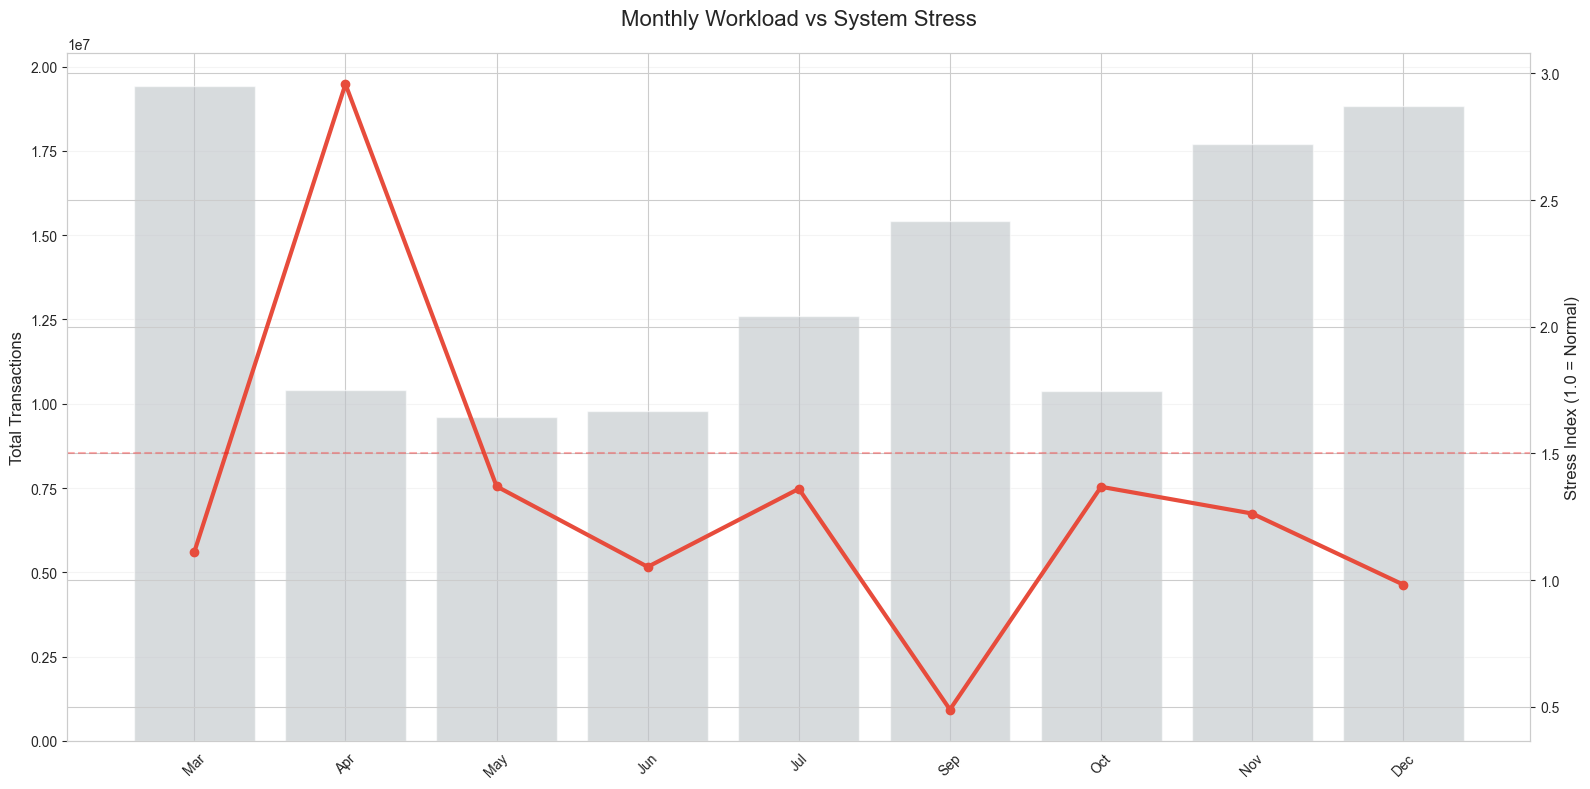

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-muted')

# Create SINGLE figure & axis
fig, ax1 = plt.subplots(figsize=(16, 8))

# Data preparation
monthly_footfall = (
    df_master.groupby('month_name')['total_footfall']
    .sum()
    .reindex(months_order)
)

monthly_stress = (
    df_master.groupby('month_name')['stress_index']
    .mean()
    .reindex(months_order)
)

# Bar plot: Total Footfall
ax1.bar(
    months_order,
    monthly_footfall,
    color='#bdc3c7',
    alpha=0.6,
    label='Total Volume'
)

ax1.set_ylabel("Total Transactions", fontsize=12)

# Line plot on twin axis: Stress Index
ax1_twin = ax1.twinx()
ax1_twin.plot(
    months_order,
    monthly_stress,
    color='#e74c3c',
    marker='o',
    linewidth=3,
    label='Avg Stress Index'
)

ax1_twin.set_ylabel("Stress Index (1.0 = Normal)", fontsize=12)

# Stress threshold line
ax1_twin.axhline(
    1.5,
    color='red',
    linestyle='--',
    alpha=0.3
)

# Title
ax1.set_title(
    "Monthly Workload vs System Stress",
    fontsize=16,
    pad=20
)

# Improve readability
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.2)

plt.tight_layout()
plt.show()
